In [12]:
import pickle
import numpy as np

In [13]:
with open('/content/drive/MyDrive/Data Science/ChatBot/train_qa.txt', 'rb') as f:
  train_data = pickle.load(f)

In [14]:
with open('/content/drive/MyDrive/Data Science/ChatBot/test_qa.txt', 'rb') as f:
  test_data = pickle.load(f)

In [15]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [16]:
all_data = test_data + train_data

In [17]:
vocab = set()

for story, question, answer in all_data:
  vocab = vocab.union(set(story))
  vocab = vocab.union(set(question))

In [18]:
vocab.add('no')

In [19]:
vocab.add('yes')

In [20]:
vocab_len = len(vocab) + 1

In [21]:
vocab_len

38

In [22]:
all_story_len = [len(data[0]) for data in all_data]

In [23]:
max_story_len = max(all_story_len)

In [24]:
all_question_len = [len(data[1]) for data in all_data]

In [25]:
max_question_len = max(all_question_len)

In [26]:
max_value = 0
max_index = -1  # Initialize with an invalid index
for index, value in enumerate(all_story_len):
    if value > max_value:
        max_value = value
        max_index = index

print(f"Max value: {max_value} at index: {max_index}")

Max value: 156 at index: 1319


In [27]:
print(max)

<built-in function max>


In [28]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [29]:
tokenizer = Tokenizer(filters= [])
tokenizer.fit_on_texts(vocab)

In [30]:
print(tokenizer.word_index)

{'there': 1, 'hallway': 2, 'apple': 3, 'put': 4, 'sandra': 5, 'office': 6, 'kitchen': 7, 'the': 8, 'discarded': 9, 'grabbed': 10, 'back': 11, 'john': 12, 'up': 13, 'got': 14, '.': 15, 'yes': 16, 'took': 17, 'mary': 18, 'garden': 19, 'went': 20, 'moved': 21, 'left': 22, 'daniel': 23, 'travelled': 24, 'to': 25, '?': 26, 'journeyed': 27, 'milk': 28, 'bedroom': 29, 'in': 30, 'picked': 31, 'is': 32, 'dropped': 33, 'down': 34, 'no': 35, 'football': 36, 'bathroom': 37}


In [31]:
train_story_text = []
train_question_text = []
train_answer_text = []

In [32]:
for story, question, answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
  train_answer_text.append(answer)

In [33]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [34]:
def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len, max_question_len = max_question_len):

  # Stories = X
  X = []
  # Questions = Xq
  Xq = []
  # answer = y
  Y = []

  for story, query, answer in data:

    x = [word_index[word.lower()] for word in story]
    xq = [word_index[word.lower()] for word in query]

    y = np.zeros(len(tokenizer.word_index) + 1)
    y[tokenizer.word_index[answer]] = 1

    X.append(x)
    Xq.append(xq)
    Y.append(y)

  return (pad_sequences(X, maxlen = max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [41]:
inputs_train, queries_train, ans_train = vectorize_stories(train_data)

In [42]:
inputs_test, queries_test, ans_test = vectorize_stories(test_data)

# ***Building the Model***

In [27]:
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM, Embedding

In [28]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [29]:
vocab_size = len(vocab) + 1

In [30]:
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(rate=0.3))

In [31]:
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_question_len))
input_encoder_c.add(Dropout(rate=0.3))

In [32]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64))
question_encoder.add(Dropout(rate=0.3))

In [33]:
question_encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [34]:
input_encoder_m = input_encoder_m(input_sequence)
input_encoder_c = input_encoder_c(input_sequence)
question_encoder = question_encoder(question)

In [35]:
match = dot([input_encoder_m, question_encoder], axes=(2,2))
match = Activation('softmax')(match)

In [36]:
response = add([match, input_encoder_c])
response = Permute((2,1))(response)

In [37]:
answer = concatenate([response, question_encoder])

In [38]:
answer

<KerasTensor shape=(None, 6, 220), dtype=float32, sparse=False, name=keras_tensor_18>

In [39]:
answer = LSTM(32)(answer)

In [40]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [41]:
answer = Activation('softmax')(answer)

In [42]:
model = Model([input_sequence, question], answer)

In [43]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [44]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 156)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 156, 64)        │          2,432 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_2 (Sequential) │ (None, 6, 64)          │          2,432 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 156, 6)         │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 156, 6)         │              0 │ dot[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_1 (Sequential) │ (None, 156, 6)         │            228 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 156, 6)         │              0 │ activation[0][0],      │
│                           │                        │                │ sequential_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, 6, 156)         │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 6, 220)         │              0 │ permute[0][0],         │
│                           │                        │                │ sequential_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 32)             │         32,384 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32)             │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 38)             │          1,254 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 38)             │              0 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 38,730 (151.29 KB)

 Trainable params: 38,730 (151.29 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
history = model.fit([inputs_train, queries_train], ans_train, batch_size=32, epochs=50, validation_data=([inputs_test, queries_test], ans_test))

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.4954 - loss: 0.6951 - val_accuracy: 0.4970 - val_loss: 0.6935
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4972 - loss: 0.6956 - val_accuracy: 0.4970 - val_loss: 0.6946
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5078 - loss: 0.6945 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4964 - loss: 0.6952 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4959 - loss: 0.6947 - val_accuracy: 0.4970 - val_loss: 0.6935
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4920 - loss: 0.6948 - val_accuracy: 0.5030 - val_loss: 0.6966
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4975 - loss: 0.6955 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5072 - loss: 0.6942 - val_accuracy: 

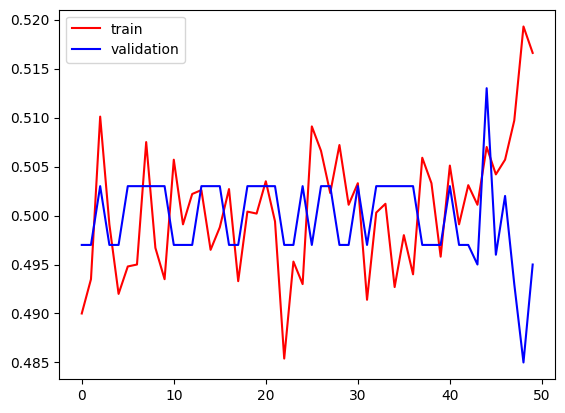

In [50]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

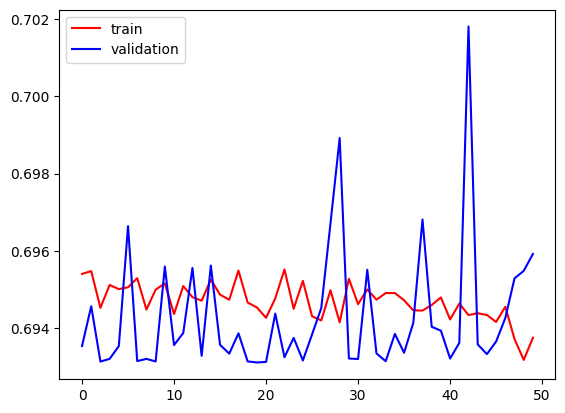

In [51]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [70]:
loaded_model.load_weights('/content/drive/MyDrive/Data Science/ChatBot/chatbot.keras')

In [53]:
y_preds = model.predict(([inputs_test, queries_test]))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [54]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [ ]:
accuracy_score(ans_test, y_preds)

In [58]:
y_preds.argmax()

20425

In [59]:
val_max = np.argmax(y_preds[0])

In [60]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [61]:
k

'got'

In [63]:
model.save('/content/drive/MyDrive/Data Science/ChatBot/chatbot.keras')

In [2]:
from keras.models import load_model

In [3]:
loaded_model = load_model('/content/drive/MyDrive/Data Science/ChatBot/chatbot.keras')

In [50]:
my_story = 'John went to kitchen . Sandra dropped the football .'
my_question = 'is sandra in the kitchen ?'
my_question2 = 'has john dropped the football ?'
my_question3 = 'has sandra dropped the football ?'
my_question4 = 'is john in the kitchen ?'

In [51]:
my_story.split()

['John',
 'went',
 'to',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 '.']

In [52]:
my_data = [(my_story.split(), my_question.split(), 'yes')]

In [53]:
my_data

[(['John',
   'went',
   'to',
   'kitchen',
   '.',
   'Sandra',
   'dropped',
   'the',
   'football',
   '.'],
  ['is', 'sandra', 'in', 'the', 'kitchen', '?'],
  'yes')]

In [54]:
my_story , my_question, my_ans = vectorize_stories(my_data)

In [75]:
pred = loaded_model.predict([my_story, my_question])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [76]:
val_max = np.argmax(pred[0])

In [77]:
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key

In [78]:
k

'office'